# Settup

In [ ]:
import os
!pip install nnunetv2
# os.kill(os.getpid(), 9)
# restart kernel after this instalatin

In [ ]:
# download our model weights
!gdown --id 1wsxlOdcL0Gjw8k9ZUt4-x-V1EqnOp0SJ
!nuzip /content/final.zip
!rm /content/final.zip

!mkdir /content/test

# download our model trainer
!gdown --id 1irRkyM2X7hipHmWI0bb5FPm2uBj4xloh
!cp /content/nnUNetTrainerDiceLoss.py /usr/local/lib/python3.10/dist-packages/nnunetv2/training/nnUNetTrainer # copy trainer to nnunet
from nnunetv2.training.nnUNetTrainer.nnUNetTrainerDiceLoss import nnUNetTrainerDiceCELoss_noSmooth

import os
import cv2
import torch
import shutil
import numpy as np
import torch.nn as nn
from PIL import Image
import nibabel as nib
import multiprocessing
import SimpleITK as sitk
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from multiprocessing import Pool
from IPython.display import clear_output
from torchvision.models.vgg import vgg19
from sklearn.preprocessing import MinMaxScaler
from batchgenerators.utilities.file_and_folder_operations import *
from nnunetv2.dataset_conversion.generate_dataset_json import generate_dataset_json

scaler = MinMaxScaler()

os.environ["nnUNet_raw"] = '/content'
os.environ["nnUNet_preprocessed"] = '/content'
os.environ["nnUNet_results"] = '/content'


  inflating: Dataset013_BraTS2021/nnUNetTrainerDiceCELoss_noSmooth__nnUNetPlans__3d_fullres/plans.json  
  inflating: Dataset013_BraTS2021/nnUNetTrainerDiceCELoss_noSmooth__nnUNetPlans__3d_fullres/dataset.json  
  inflating: Dataset013_BraTS2021/nnUNetTrainerDiceCELoss_noSmooth__nnUNetPlans__3d_fullres/dataset_fingerprint.json  


In [ ]:
def percentage(part, whole):
  Percentage = 100 * part/whole
  return str(round(Percentage)) + "%"

## Zero-learning Fusion

https://github.com/bsun0802/Zero-Learning-Fast-Medical-Image-Fusion

In [ ]:
class VGG19(torch.nn.Module):
    def __init__(self, device='cuda'):
        super(VGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        if device == "cuda":
            self.features = nn.ModuleList(features).cuda().eval()
        else:
            self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        feature_maps = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx == 3:
                feature_maps.append(x)
        return feature_maps


class Fusion:
    def __init__(self, input):
        """
        Class Fusion constructor

        Instance Variables:
            self.images: input images
            self.model: CNN model, default=vgg19
            self.device: either 'cuda' or 'cpu'
        """
        self.input_images = input
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VGG19(self.device)

    def fuse(self):
        """
        A top level method which fuse self.images
        """
        # Convert all images to YCbCr format
        self.normalized_images = [-1 for img in self.input_images]
        self.YCbCr_images = [-1 for img in self.input_images]
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx] = self._RGB_to_YCbCr(img)
                self.normalized_images[idx] = self.YCbCr_images[idx][:, :, 0]
            else:
                self.normalized_images[idx] = img / 255.
        # Transfer all images to PyTorch tensors
        self._tranfer_to_tensor()
        # Perform fuse strategy
        fused_img = self._fuse()[:, :, 0]
        # Reconstruct fused image given rgb input images
        for idx, img in enumerate(self.input_images):
            if not self._is_gray(img):
                self.YCbCr_images[idx][:, :, 0] = fused_img
                fused_img = self._YCbCr_to_RGB(self.YCbCr_images[idx])
                fused_img = np.clip(fused_img, 0, 1)

        return (fused_img * 255).astype(np.uint8)

    def _fuse(self):
        """
        Perform fusion algorithm
        """
        with torch.no_grad():

            imgs_sum_maps = [-1 for tensor_img in self.images_to_tensors]
            for idx, tensor_img in enumerate(self.images_to_tensors):
                imgs_sum_maps[idx] = []
                feature_maps = self.model(tensor_img)
                for feature_map in feature_maps:
                    sum_map = torch.sum(feature_map, dim=1, keepdim=True)
                    imgs_sum_maps[idx].append(sum_map)

            max_fusion = None
            for sum_maps in zip(*imgs_sum_maps):
                features = torch.cat(sum_maps, dim=1)
                weights = self._softmax(F.interpolate(features,
                                        size=self.images_to_tensors[0].shape[2:]))
                weights = F.interpolate(weights,
                                        size=self.images_to_tensors[0].shape[2:])
                current_fusion = torch.zeros(self.images_to_tensors[0].shape)
                for idx, tensor_img in enumerate(self.images_to_tensors):
                    current_fusion += tensor_img * weights[:,idx]
                if max_fusion is None:
                    max_fusion = current_fusion
                else:
                    max_fusion = torch.max(max_fusion, current_fusion)

            output = np.squeeze(max_fusion.cpu().numpy())
            if output.ndim == 3:
                output = np.transpose(output, (1, 2, 0))
            return output

    def _RGB_to_YCbCr(self, img_RGB):
        """
        A private method which converts an RGB image to YCrCb format
        """
        img_RGB = img_RGB.astype(np.float32) / 255.
        return cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)

    def _YCbCr_to_RGB(self, img_YCbCr):
        """
        A private method which converts a YCrCb image to RGB format
        """
        img_YCbCr = img_YCbCr.astype(np.float32)
        return cv2.cvtColor(img_YCbCr, cv2.COLOR_YCrCb2RGB)

    def _is_gray(self, img):
        """
        A private method which returns True if image is gray, otherwise False
        """
        if len(img.shape) < 3:
            return True
        if img.shape[2] == 1:
            return True
        b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
        if (b == g).all() and (b == r).all():
            return True
        return False

    def _softmax(self, tensor):
        """
        A private method which compute softmax ouput of a given tensor
        """
        tensor = torch.exp(tensor)
        tensor = tensor / tensor.sum(dim=1, keepdim=True)
        return tensor

    def _tranfer_to_tensor(self):
        """
        A private method to transfer all input images to PyTorch tensors
        """
        self.images_to_tensors = []
        for image in self.normalized_images:
            np_input = image.astype(np.float32)
            if np_input.ndim == 2:
                np_input = np.repeat(np_input[None, None], 3, axis=1)
            else:
                np_input = np.transpose(np_input, (2, 0, 1))[None]
            if self.device == "cuda":
                self.images_to_tensors.append(torch.from_numpy(np_input).cuda())
            else:
                self.images_to_tensors.append(torch.from_numpy(np_input))


# NOTE!! Uplode files in **test** directory with following format:

test/

  ├─ t2w.nii.gz

  ├─ t1c.nii.gz

  ├─ t1n.nii.gz

  └─ t2f.nii.gz

**Guide:**

t1n --> T1

t1c --> T1CE

t2w --> T2

t2f --> Flair

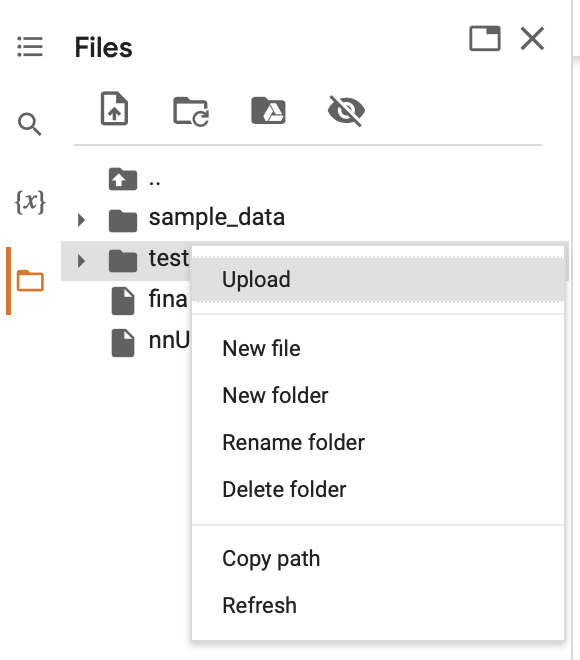

# Apply Fusion

In [ ]:
# apply 3 fusion that we used for our model: 't1n-t1c', 't1c-t2f', 't1c-t2w'

def normalizer(image):
    img_min = np.min(image)
    img_max = np.max(image)
    image = (image - img_min ) / ( img_max - img_min)
    image = image * 255
    return image

def zero_learning_fusion(input_images):
  FU = Fusion(input_images)
  fusion_img = FU.fuse()
  return fusion_img

base_dir = '/content/test/'
# images_path = os.listdir(base_dir)

fusion_modes = ['t1n-t1c', 't1c-t2f', 't1c-t2w']

images = []

for i, mode in enumerate(fusion_modes):
    Final_fusion3D = ''
    images = [nib.load(base_dir + '{}.nii.gz'.format(mode.split('-')[0])).get_fdata()]
    images.append(nib.load(base_dir + '{}.nii.gz'.format(mode.split('-')[1])).get_fdata())
    for slice_num in range(155):
        if (slice_num%10) == 0:
          clear_output()
          print(percentage(155*i + slice_num + 1, 155*3))
        slices = [normalizer(image[:,:,slice_num]) for image in images]
        fusion = zero_learning_fusion(slices)
        if slice_num == 0:
            Final_fusion3D = fusion
        else:
            Final_fusion3D = np.dstack((Final_fusion3D ,fusion))

    output = nib.Nifti1Image(Final_fusion3D, np.eye(4))
    output.header.get_xyzt_units()
    output.to_filename(base_dir + '{}.nii.gz'.format(mode))
    print(mode)

99%
t1c-t2w


# Prediction

In [ ]:
# Apply data conversion for nnunet

!mkdir /content/input
imagestr = '/content/input/'

shutil.copy(join(base_dir + "t1n-t1c.nii.gz"), join(imagestr + 'Brain_0000.nii.gz'))
shutil.copy(join(base_dir, "t2f.nii.gz"), join(imagestr + 'Brain_0001.nii.gz'))
shutil.copy(join(base_dir + "t1c-t2w.nii.gz"), join(imagestr + 'Brain_0002.nii.gz'))
shutil.copy(join(base_dir + "t1c-t2f.nii.gz"), join(imagestr + 'Brain_0003.nii.gz'))

mkdir: cannot create directory ‘/content/input’: File exists


'/content/input/Brain_0003.nii.gz'

In [ ]:
!nnUNetv2_predict -i /content/input -o /content/output -d 13 -c 3d_fullres -f all -tr nnUNetTrainerDiceCELoss_noSmooth

In [ ]:
# remove all non nifti files

for i in os.listdir('/content/output'):
  if not('.nii.gz' in i):
    p = '/content/output/' + i
    !rm -rf $p

# Show Output

## 2D

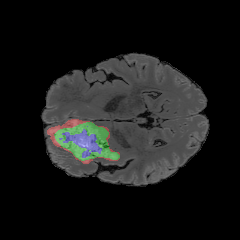

In [ ]:
slice_num = 70

main_img = nib.load('/content/test/t2f.nii.gz').get_fdata()
main_img = scaler.fit_transform(main_img.reshape(-1, main_img.shape[-1])).reshape(main_img.shape)[:,:,slice_num]

seg = nib.load('/content/output/Brain.nii.gz').get_fdata()
seg = scaler.fit_transform(seg.reshape(-1, seg.shape[-1])).reshape(seg.shape)[:,:,slice_num]

main = Image.fromarray(np.uint8(cm.gist_earth(main_img)*255))
main_converter = Image.fromarray(np.uint8(cm.gist_earth(main_img)*255)).convert('L')
seg = Image.fromarray(np.uint8(cm.gist_earth(seg)*255))

a = 75
main.putalpha(255)
seg.putalpha(a)

pixels = seg.load()
for i in range(seg.size[0]):
    for j in range(seg.size[1]):
      if pixels[i,j] == (169, 179, 91, a):
        pixels[i,j] = (255, 0, 0, a)
      elif pixels[i,j] == (253, 250, 250, a):
        pixels[i,j] = (0, 255, 0, a)
      elif pixels[i,j] == (54, 135, 111, a):
        pixels[i,j] = (0, 0, 255, a)

pixels = main.load()
change_pixels = main_converter.load()
for i in range(seg.size[0]):
    for j in range(seg.size[1]):
      pixels[i,j] = (change_pixels[i,j], change_pixels[i,j], change_pixels[i,j], 255)

f = Image.alpha_composite(main, seg).convert('RGB')
f.save("/content/final_2d.jpg", quality=100)
f

## 3D

In [ ]:
main_img = nib.load('/content/test/t2f.nii.gz').get_fdata()
main_img = scaler.fit_transform(main_img.reshape(-1, main_img.shape[-1])).reshape(main_img.shape)

seg = nib.load('/content/output/Brain.nii.gz').get_fdata()
seg = scaler.fit_transform(seg.reshape(-1, seg.shape[-1])).reshape(seg.shape)

a = 75

for slice_num in range(155):

    main_slice = Image.fromarray(np.uint8(cm.gist_earth(main_img[:,:,slice_num])*255))
    seg_slice = Image.fromarray(np.uint8(cm.gist_earth(seg[:,:,slice_num])*255))
    main_converter_slice =Image.fromarray(np.uint8(cm.gist_earth(main_img[:,:,slice_num])*255)).convert('L')
    main_slice.putalpha(255)
    seg_slice.putalpha(a)

    pixels = seg_slice.load()
    main_pixels = main_slice.load()
    change_pixels = main_converter_slice.load()
    for i in range(seg_slice.size[0]):
        for j in range(seg_slice.size[1]):
          main_pixels[i,j] = (change_pixels[i,j], change_pixels[i,j], change_pixels[i,j], 255)
          if pixels[i,j] == (169, 179, 91, a):
            pixels[i,j] = (255, 0, 0, a)
          elif pixels[i,j] == (253, 250, 250, a):
            pixels[i,j] = (0, 255, 0, a)
          elif pixels[i,j] == (54, 135, 111, a):
            pixels[i,j] = (0, 0, 255, a)

    final = Image.alpha_composite(main_slice, seg_slice).convert('RGB')

    if slice_num == 70:
        Final = final
    else:
        Final = np.dstack((Final ,final))

output = nib.Nifti1Image(Final, np.eye(4))
output.header.get_xyzt_units()
output.to_filename('/content/' + 'final_3d.nii.gz')